In [1]:
from datetime import datetime, timedelta
from netCDF4 import Dataset


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob

import numpy as np
import math


from netCDF4 import Dataset

import pandas as pd
import xarray as xr
from siphon.catalog import TDSCatalog
from xarray.backends import NetCDF4DataStore

from metpy.calc import reduce_point_density
import metpy.calc as mpcalc
import metpy.plots as mpplots
from metpy.plots import StationPlot, wx_code_to_numeric
from metpy.plots.wx_symbols import sky_cover, current_weather
from metpy.units import units
from metpy.interpolate import interpolate_to_grid, remove_nan_observations, interpolate_to_points
from metpy.io import metar


from metpy.plots.declarative import (BarbPlot, ContourPlot, FilledContourPlot, MapPanel,
                                     PanelContainer, PlotObs)

In [2]:
UNIX_TIME = datetime(1970,1,1,0)

### Pressure Level, Date, Time, and Domain
The user can choose a mandatory pressure level, date, time, and domain to plot data. 

In [3]:
pres_lev = 300

#set time to plot
start_year  = 2020
start_month = 8
start_day   = 15
start_hour  = 0
#start_min   = 0
    
#set plot domain
lat_min = 22
lat_max = 50
lon_min = -130
lon_max = -70
    
dt = datetime(start_year,start_month,start_day,start_hour)
del_t = datetime.now()-dt
del_t_days = del_t.days + (del_t.seconds/60/60/24)

In [4]:
#get raob data
import requests
import gzip
import shutil

#download and extract the data

if del_t_days>3:
    base_url = 'https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/archive/'
    url = f'{base_url}{dt:%Y}/{dt:%m}/{dt:%d}/point/raob/netcdf/{dt:%Y%m%d_%H%M}.gz'
    print(url)
    r = requests.get(url,allow_redirects=True)
    open('temp.nc.gz','wb').write(r.content)
    with gzip.open('temp.nc.gz','rb') as f_in:
        with open('temp.nc','wb') as f_out:
            shutil.copyfileobj(f_in,f_out)
    data=Dataset('temp.nc','r')

else:
    base_url = 'https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/point/raob/netcdf/'
    url = f'{base_url}{dt:%Y%m%d_%H%M}.gz'
    print(url)
    r = requests.get(url,allow_redirects=True)
    open('temp.nc.gz','wb').write(r.content)
    with gzip.open('temp.nc.gz','rb') as f_in:
        with open('temp.nc','wb') as f_out:
            shutil.copyfileobj(f_in,f_out)
    data=Dataset('temp.nc','r')

https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/archive/2020/08/15/point/raob/netcdf/20200815_0000.gz


In [5]:
time = [UNIX_TIME + timedelta(seconds=float(t)) for t in data['synTime']]
lat = data['staLat'][:]
lat = lat.filled(np.nan)
lon = data['staLon'][:]
lon = lon.filled(np.nan)
pres = data['prMan'][:]
pres = pres.filled(np.nan)
hght = data['htMan'][:]
hght = hght.filled(np.nan)
temp = data['tpMan'][:]
temp = temp.filled(np.nan)
temp[temp<100]=np.nan
temp = (temp-273.15)
dwptdp = data['tdMan'][:]
dwptdp = dwptdp.filled(np.nan)
dwptdp[dwptdp<100]=np.nan
dwptdp = (dwptdp-273.15)
wdir = data['wdMan'][:]
wdir = wdir.filled(np.nan)
wdir[wdir<0] = np.nan
wspd = data['wsMan'][:]
wspd = wspd.filled(np.nan)
wspd[wspd>250] = np.nan

name = data['staName'][:]
name = [i.tostring().decode()[:4] for i in name]
u,v = mpcalc.wind_components((wspd*units('m/s')).to('knots'),wdir*units.degree)

#u = np.abs(wspd) * np.cos(np.deg2rad(270-wdir))
#u[np.abs(u)>250] = np.nan
#v = np.abs(wspd) * np.sin(np.deg2rad(270-wdir))
#v[np.abs(v)>250] = np.nan

#u=u*units['kts']
#v=v*units['kts']
#df = pd.DataFrame(np.transpose(np.array([time,name,name,lon,lat,u,v,temp,dwptdp,pres,hght])),
 #                     columns = ['time','id','name','lon','lat','u','v','temp','dwptdp','pres','hght'])

print(len(name))

ds = xr.Dataset(
        coords=dict(
            id=(['id'],name)
            ),
        data_vars=dict(
            lon=(['id'],lon),
            lat=(['id'],lat),
            pressure=(['id','pres'],pres),
            height=(['id','pres'],hght),
            temperature=(['id','pres'],temp),
            dwptdp=(['id','pres'],dwptdp),
            u=(['id','pres'],u),
            v=(['id','pres'],v)
            )
    )

#convert to pandas dataframe and remove obs with nans for lat/lon
df=ds.to_dataframe()
df=df[df['lat'].notna()]
df=df[df['lon'].notna()]
print(df)

455
                 lon    lat  pressure       height  temperature  dwptdp  \
id   pres                                                                 
MKPB 0    -59.500000  13.07    1005.0    47.000000    27.600006     NaN   
     1    -59.500000  13.07    1000.0    92.040817    27.200012     NaN   
     2    -59.500000  13.07     925.0   777.040771    22.200012     NaN   
     3    -59.500000  13.07     850.0  1510.000000    19.399994     NaN   
     4    -59.500000  13.07     700.0  3158.979492    11.600006     NaN   
...              ...    ...       ...          ...          ...     ...   
CYLT 17   -62.349998  82.50       NaN          NaN          NaN     NaN   
     18   -62.349998  82.50       NaN          NaN          NaN     NaN   
     19   -62.349998  82.50       NaN          NaN          NaN     NaN   
     20   -62.349998  82.50       NaN          NaN          NaN     NaN   
     21   -62.349998  82.50       NaN          NaN          NaN     NaN   

                   u

/var/folders/06/psvnwwys3wb8jvz_dtrft5080000gn/T/ipykernel_41862/3830421368.py:26: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  name = [i.tostring().decode()[:4] for i in name]


In [6]:
#get rap data
try:
    base_url = 'https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl/'
    cat = TDSCatalog(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml')
    ds = cat.datasets.filter_time_range(dt,dt+timedelta(hours=0))[-1]
    ncss = ds.subset()
except requests.exceptions.HTTPError as err:
    try:
        base_url = 'https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/'
        cat = TDSCatalog(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml')
        ds = cat.datasets.filter_time_range(dt,dt+timedelta(hours=0))[-1]
        ncss = ds.subset()
    except requests.exceptions.HTTPError as err:
        print("   Date not in catalog.  Exiting...\n")
        sys.exit()

query = ncss.query()
query.lonlat_box(north=lat_max+3,south=lat_min-3,east=lon_max+3,west=lon_min-3)
query.all_times()
query.add_lonlat()
query.accept('netcdf')
query.variables('Geopotential_height_isobaric',
                    'Relative_humidity_isobaric',
                    'u-component_of_wind_isobaric',
                    'v-component_of_wind_isobaric',
                    'Temperature_isobaric')
                        
    
rap_data = ncss.get_data(query)
rap_ds = xr.open_dataset(NetCDF4DataStore(rap_data)).metpy.parse_cf()

rap_temp = np.array(rap_ds['Temperature_isobaric'][0].metpy.sel(vertical=pres_lev*units.hPa))[::5,::5]
rap_rh = np.array(rap_ds['Relative_humidity_isobaric'][0].metpy.sel(vertical=pres_lev*units.hPa))[::5,::5]
rap_u = np.array(rap_ds['u-component_of_wind_isobaric'][0].metpy.sel(vertical=pres_lev*units.hPa))[::5,::5]
rap_v = np.array(rap_ds['v-component_of_wind_isobaric'][0].metpy.sel(vertical=pres_lev*units.hPa))[::5,::5]
rap_hgt = np.array(rap_ds['Geopotential_height_isobaric'][0].metpy.sel(vertical=pres_lev*units.hPa))[::5,::5]
rap_lon = np.array(rap_ds.lon)[::5,::5]
rap_lat = np.array(rap_ds.lat)[::5,::5]

rap_ds['wind_speed'] = mpcalc.wind_speed(rap_ds['u-component_of_wind_isobaric'],
                                     rap_ds['v-component_of_wind_isobaric'])
rap_wspd = np.array(rap_ds['wind_speed'][0].metpy.sel(vertical=pres_lev*units.hPa))[::5,::5]

### Subset based on vertical level
Users can choose between mandatory levels (925, 850, 700, 500, 400, 300, 250, and 200 mb) to plot. The data gets put into a subset based on the pressure level.

In [32]:
df_sub = df[df['pressure']==pres_lev]
#print(rap_rh)
#print(np.shape(rap_rh))
#print(df_sub)
print(rap_ds)

<xarray.Dataset>
Dimensions:                       (time: 1, isobaric: 37, y: 298, x: 451)
Coordinates:
  * time                          (time) datetime64[ns] 2020-08-15
  * isobaric                      (isobaric) float32 1e+04 1.25e+04 ... 1e+05
  * y                             (y) float32 -3.586e+05 ... 3.664e+06
  * x                             (x) float32 -3.332e+06 ... 2.763e+06
    metpy_crs                     object Projection: lambert_conformal_conic
Data variables:
    u-component_of_wind_isobaric  (time, isobaric, y, x) float32 -11.06 ... -...
    LambertConformal_Projection   int32 ...
    lat                           (y, x) float64 18.28 18.31 ... 53.3 53.27
    lon                           (y, x) float64 -126.6 -126.5 ... -58.62 -58.45
    Relative_humidity_isobaric    (time, isobaric, y, x) float32 ...
    Temperature_isobaric          (time, isobaric, y, x) float32 ...
    v-component_of_wind_isobaric  (time, isobaric, y, x) float32 2.493 ... -0...
    Geopotentia

In [14]:
search_radius = 120000 

proj = ccrs.LambertConformal(central_latitude=(lat_min+lat_max) / 2,
                                     central_longitude=(lon_min+lon_max) / 2)

hghtdf = df_sub.dropna(subset=['height'],inplace=False)

bounds_locs = proj.transform_points(ccrs.PlateCarree(),np.array([lon_min,lon_max]),np.array([lat_max,lat_min]))

bounds = dict({'north':bounds_locs[0,1],'east':bounds_locs[1,0],'south':bounds_locs[1,1],'west':bounds_locs[0,0]})

print(bounds)

point_locs = proj.transform_points(ccrs.PlateCarree(),df_sub['lon'].values,df_sub['lat'].values)
point_locs_hght = proj.transform_points(ccrs.PlateCarree(),hghtdf['lon'].values,hghtdf['lat'].values)
xp,yp,null = point_locs_hght.T
stns = np.transpose([xp,yp])


rap_locs = proj.transform_points(ccrs.PlateCarree(),rap_lon.flatten(),rap_lat.flatten())
rxp,ryp,null = rap_locs.T
rap_locs = np.transpose([rxp,ryp])

#import sys
#sys.exit()

hghtgridx, hghtgridy, rap_height = interpolate_to_grid(rxp,ryp,rap_hgt.flatten(),
                                            interp_type='cressman',
                                            minimum_neighbors=1,hres=50000,boundary_coords=bounds,
                                            search_radius=search_radius)

hght_bg = interpolate_to_points(rap_locs,rap_hgt.flatten(),stns,interp_type='cressman',search_radius=search_radius)
dhgt = hghtdf['height'].values-hght_bg

hghtgridx, hghtgridy, height = interpolate_to_grid(xp,yp,dhgt,
                                            interp_type='cressman',
                                            minimum_neighbors=1,hres=50000,boundary_coords=bounds,
                                            search_radius=search_radius)
print(dhgt)
print(height.shape)
print(rap_height.shape)

height = np.nansum([height,rap_height],axis=0)


{'north': 1911336.4211668544, 'east': 3154229.39360703, 'south': -1044518.0541340541, 'west': -2141356.0613441523}
[            nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan  9.53676068e+00  7.85097412e+00
  5.38668264e+00  2.43881080e+01  2.56354977e+01  1.25898779e+01
  1.52827479e+01  1.47609653e+01  3.23740529e+01  2.18855649e+01
 -1.39533213e+01  8.53910846e+00  7.54472014e+00  8.20706853e+00
 -1.34413371e+01  2.00321751e+01 -2.71656211e+00  1.48717652e+01
  1.38151522e+01 -7.03490572e+00  3.39196162e+00  1.43022440e+01
  1.02955019e+01  1.32118806e+01  4.09741712e+00  3.58717735e+00
 -3.82293864e+00 -1.48123669e-02  1.12362625e+01  7.38200990e+00
  8.63510602e+00  1.82908794e+01  1.93982813e+01  4.86995219e+00
  3.94106444e+00  1.23877325e+01  1.21808510e+00  1.40936991e+01
  6.01559469e+00  6.54060326e+00  4.7802

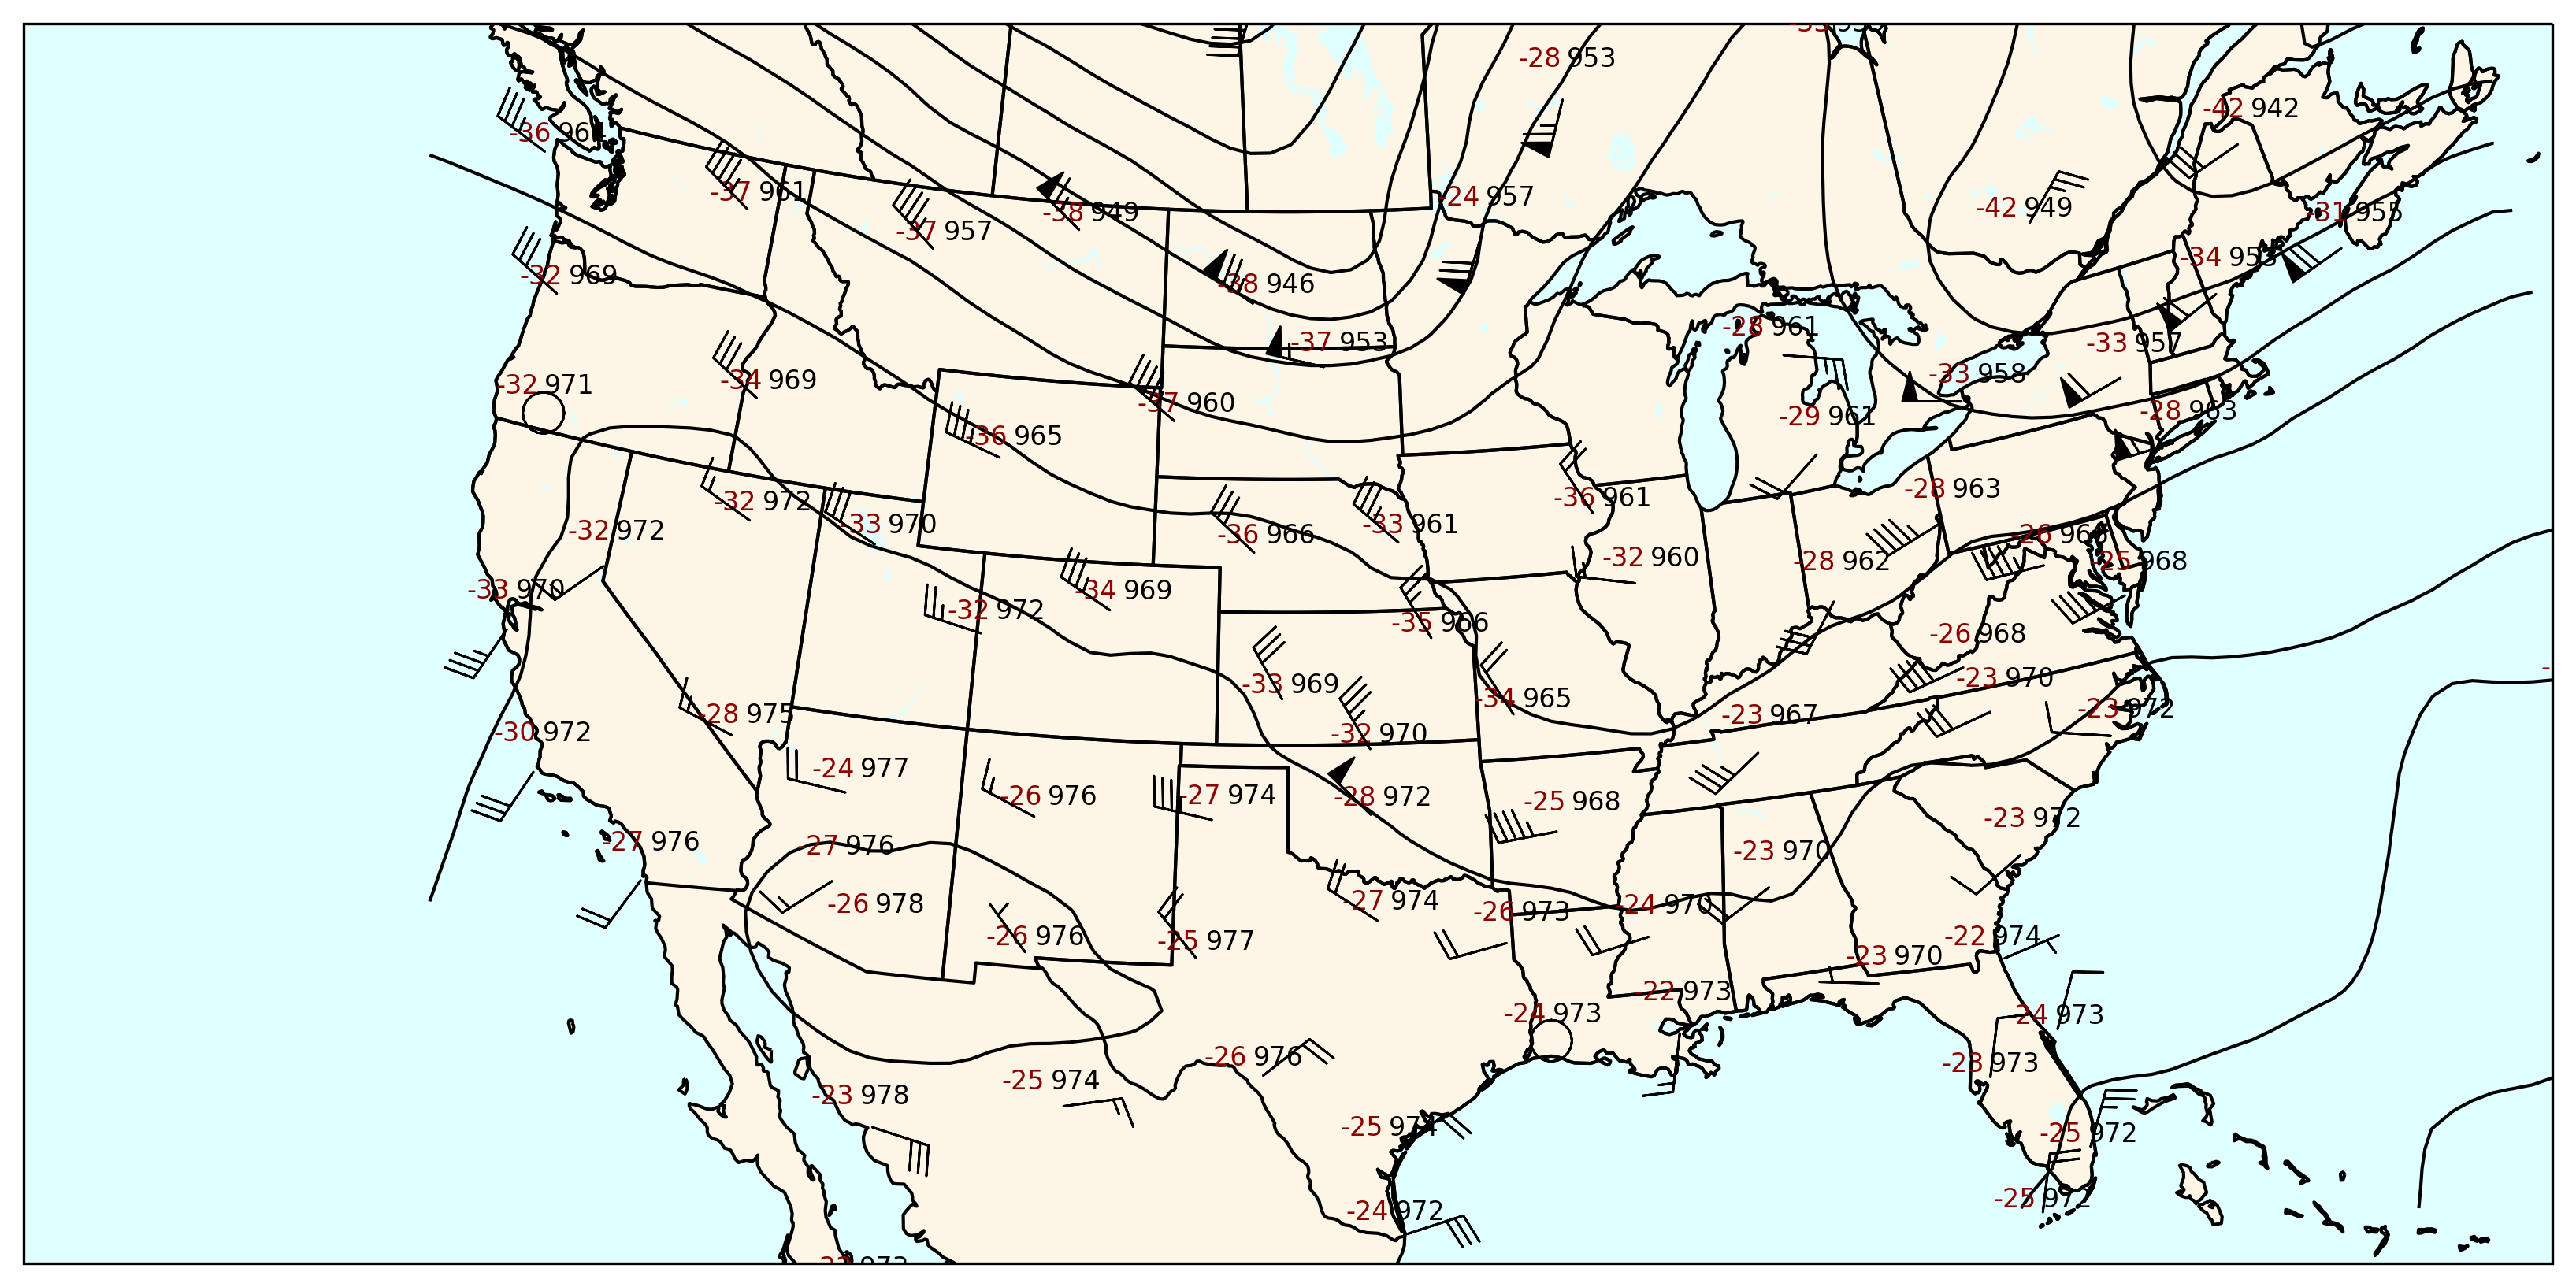

In [15]:
if pres_lev == 925:
    pre_ctours = np.arange(500,900,30)
elif pres_lev == 850:
    pre_ctours = np.arange(1100,1900,30)
elif pres_lev == 700:
    pre_ctours = np.arange(2400,3600,30)
elif pres_lev == 500:
    pre_ctours = np.arange(4000,6500,60)
elif pres_lev == 400:
    pre_ctours = np.arange(6800,8000,60)
elif pres_lev == 300:
    pre_ctours = np.arange(8200,10400,60)
elif pres_lev == 250:
    pre_ctours = np.arange(10000,11500,60)
elif pres_lev == 200:
    pre_ctours = np.arange(10900,13000,60)

fig=plt.figure(figsize=(11,6.5),dpi=300)
proj = ccrs.LambertConformal(central_latitude=(lat_min+lat_max) / 2,
                                     central_longitude=(lon_min+lon_max) / 2)
ax = fig.add_subplot(1,1,1,projection=proj)
#img = plt.imread('../basemaps/natural_earth.tif')
#img_extent = (-180,180,-90,90)
#ax.imshow(img,origin='upper',extent=img_extent,transform=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical','land','50m',facecolor='oldlace'))
ax.add_feature(cfeature.NaturalEarthFeature('physical','ocean','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.NaturalEarthFeature('physical','lakes','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

stationplot = StationPlot(ax,df_sub['lon'].values,df_sub['lat'].values,clip_on=True, transform=ccrs.PlateCarree(),fontsize=8)
#stationplot.plot_text((2.1,0),df_plot['name'].values,fontsize=4,color='gray')
stationplot.plot_parameter('NW',df_sub['temperature']*(9.0/5.0)+32.0,color='darkred',fontsize=8)
stationplot.plot_parameter('NE',df_sub['height'],color='black',formatter=lambda v: format(v, '.0f')[:3],fontsize=8)
stationplot.plot_parameter('SW',df_sub['dwptdp']*(9.0/5.0)+32.0,color='darkgreen',fontsize=8)
stationplot.plot_barb(np.array(df_sub['u'].values,dtype=float),np.array(df_sub['v'].values,dtype=float),linewidth=0.7,length=6,zorder=10)

cs = plt.contour(hghtgridx,hghtgridy,rap_height,colors='k',levels=pre_ctours,linewidths=1)
cs = plt.contourf(rap_wspd)

#plt.clabel(cs, inline=1, fontsize=8, fmt='%i')
#stationplot.plot_symbol('C',df['sky_cvr'].values,sky_cover)
#stationplot.plot_symbol('W',df['wx'].values,current_weather,fontsize=12)
#plt.suptitle(dt_str)
fig.tight_layout()

plt.show()

In [17]:
#print(hghtgridy)
print(np.shape(rap_u))
print(np.shape(rap_v))
print(np.shape(rap_rh))
print(np.shape(rap_temp))
print(np.shape(rap_lat))
print(np.shape(rap_lon))
print(np.shape(rap_wspd))
print(np.shape(rap_hgt))
print(rap_lat)

(60, 91)
(60, 91)
(60, 91)
(60, 91)
(60, 91)
(60, 91)
(60, 91)
(60, 91)
[[18.27851216 18.41704588 18.55291692 ... 19.58787013 19.47480403
  19.35898609]
 [18.86731382 19.00664    19.14328657 ... 20.18409081 20.07039039
  19.95392143]
 [19.45659634 19.59670813 19.73412344 ... 20.78072552 20.66639672
  20.54928281]
 ...
 [50.7306479  50.89829492 51.06255238 ... 52.30826044 52.17264255
  52.03360332]
 [51.2455887  51.41339719 51.5778092  ... 52.82456958 52.68884749
  52.54969878]
 [51.75756332 51.92552079 52.09007507 ... 53.33779384 53.20197784
  53.06273019]]


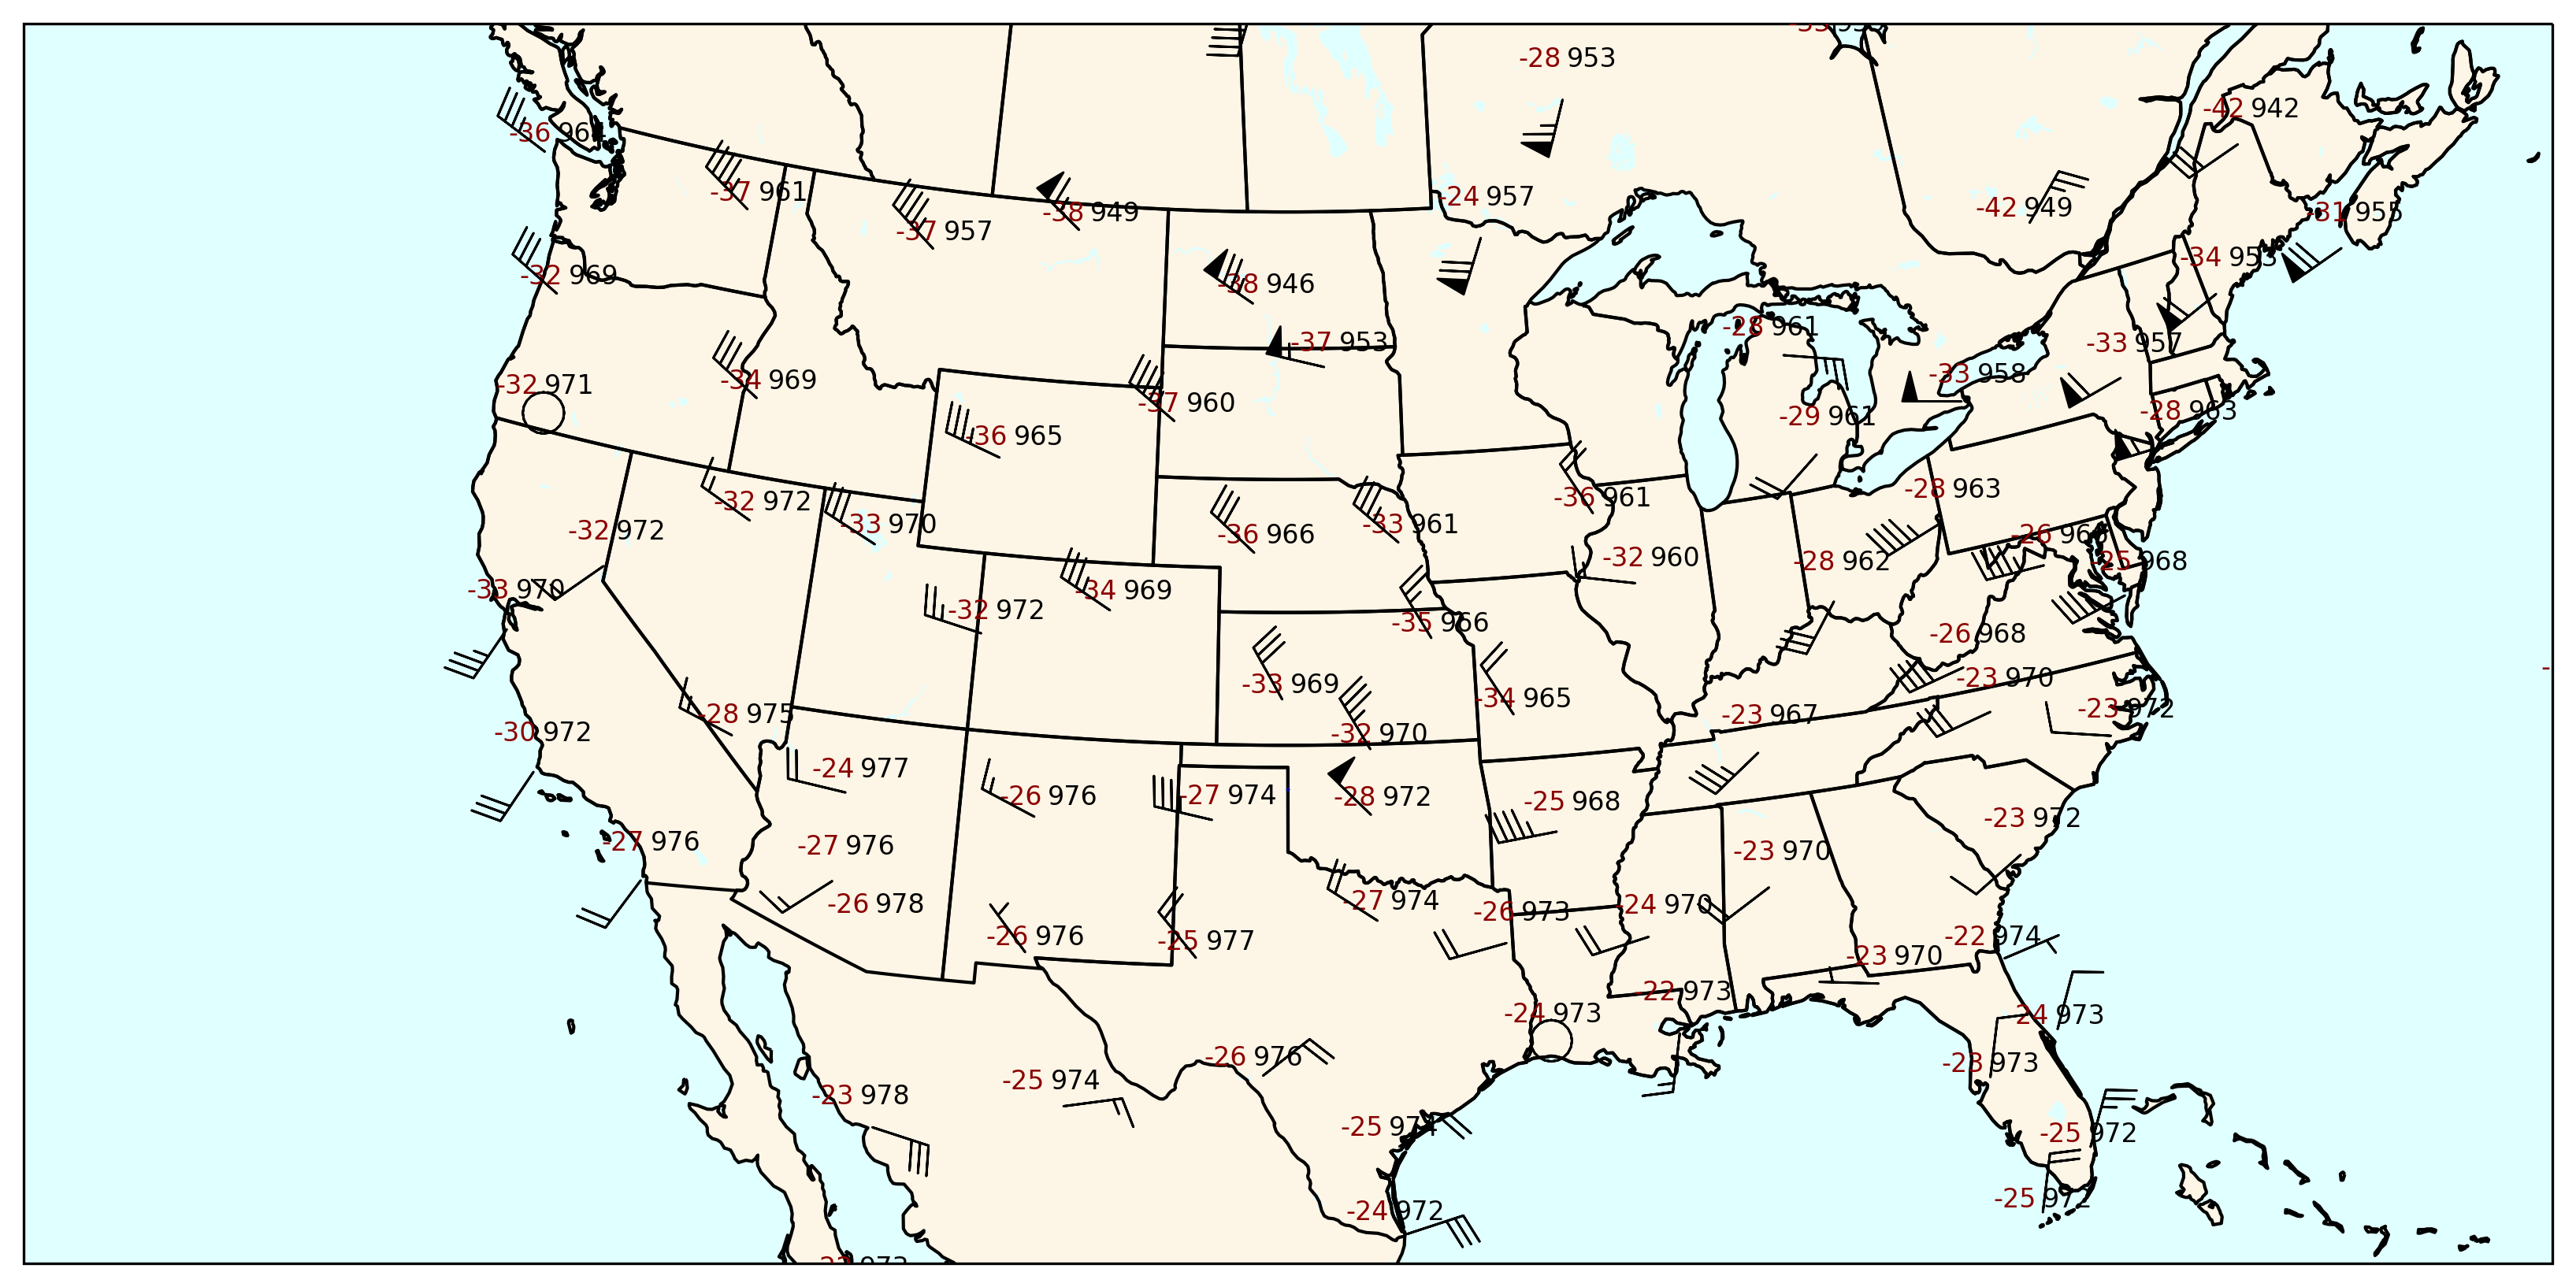

In [18]:
fig=plt.figure(figsize=(11,6.5),dpi=300)
proj = ccrs.LambertConformal(central_latitude=(lat_min+lat_max) / 2,
                                     central_longitude=(lon_min+lon_max) / 2)
ax = fig.add_subplot(1,1,1,projection=proj)
#img = plt.imread('../basemaps/natural_earth.tif')
#img_extent = (-180,180,-90,90)
#ax.imshow(img,origin='upper',extent=img_extent,transform=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical','land','50m',facecolor='oldlace'))
ax.add_feature(cfeature.NaturalEarthFeature('physical','ocean','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.NaturalEarthFeature('physical','lakes','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

stationplot = StationPlot(ax,df_sub['lon'].values,df_sub['lat'].values,clip_on=True, transform=ccrs.PlateCarree(),fontsize=8)
#stationplot.plot_text((2.1,0),df_plot['name'].values,fontsize=4,color='gray')
stationplot.plot_parameter('NW',df_sub['temperature']*(9.0/5.0)+32.0,color='darkred',fontsize=8)
stationplot.plot_parameter('NE',df_sub['height'],color='black',formatter=lambda v: format(v, '.0f')[:3],fontsize=8)
stationplot.plot_parameter('SW',df_sub['dwptdp']*(9.0/5.0)+32.0,color='darkgreen',fontsize=8)
stationplot.plot_barb(np.array(df_sub['u'].values,dtype=float),np.array(df_sub['v'].values,dtype=float),linewidth=0.7,length=6,zorder=10)

colormap = cm.get_cmap('seismic')
cs = plt.contour(rap_wspd,cmap=colormap,levels=list(range(10,201,20)),linewidths=1)

#plt.clabel(cs, inline=1, fontsize=8, fmt='%i')
#stationplot.plot_symbol('C',df['sky_cvr'].values,sky_cover)
#stationplot.plot_symbol('W',df['wx'].values,current_weather,fontsize=12)
#plt.suptitle(dt_str)
fig.tight_layout()

plt.show()

In [37]:
# Set attributes for plotting color-filled contours of wind speed at 300 hPa
cfill = FilledContourPlot()
cfill.data = rap_ds
cfill.field = 'wind_speed'
cfill.level = 300 * units.hPa
#cfill.time = plot_time
cfill.contours = list(range(10, 201, 20))
cfill.colormap = 'BuPu'
cfill.colorbar = 'horizontal'
cfill.plot_units = 'kts'

In [38]:
# Set the attributes for the map and add our data to the map
panel = MapPanel()
panel.area = [-125, -74, 20, 55]
panel.projection = 'lcc'
panel.layers = ['states', 'coastline', 'borders']
panel.title = f'{cfill.level.m}-hPa Heights and Wind Speed at'
panel.plots = [cfill]

In [39]:
pc = PanelContainer()
pc.size = (15, 15)
pc.panels = [panel]

/Users/joshuanielsen/opt/anaconda3/envs/atsc528/lib/python3.10/site-packages/metpy/xarray.py:460: UserWarning: Latitude and longitude computed on-demand, which may be an expensive operation. To avoid repeating this computation, assign these coordinates ahead of time with .metpy.assign_latitude_longitude().
  warnings.warn(


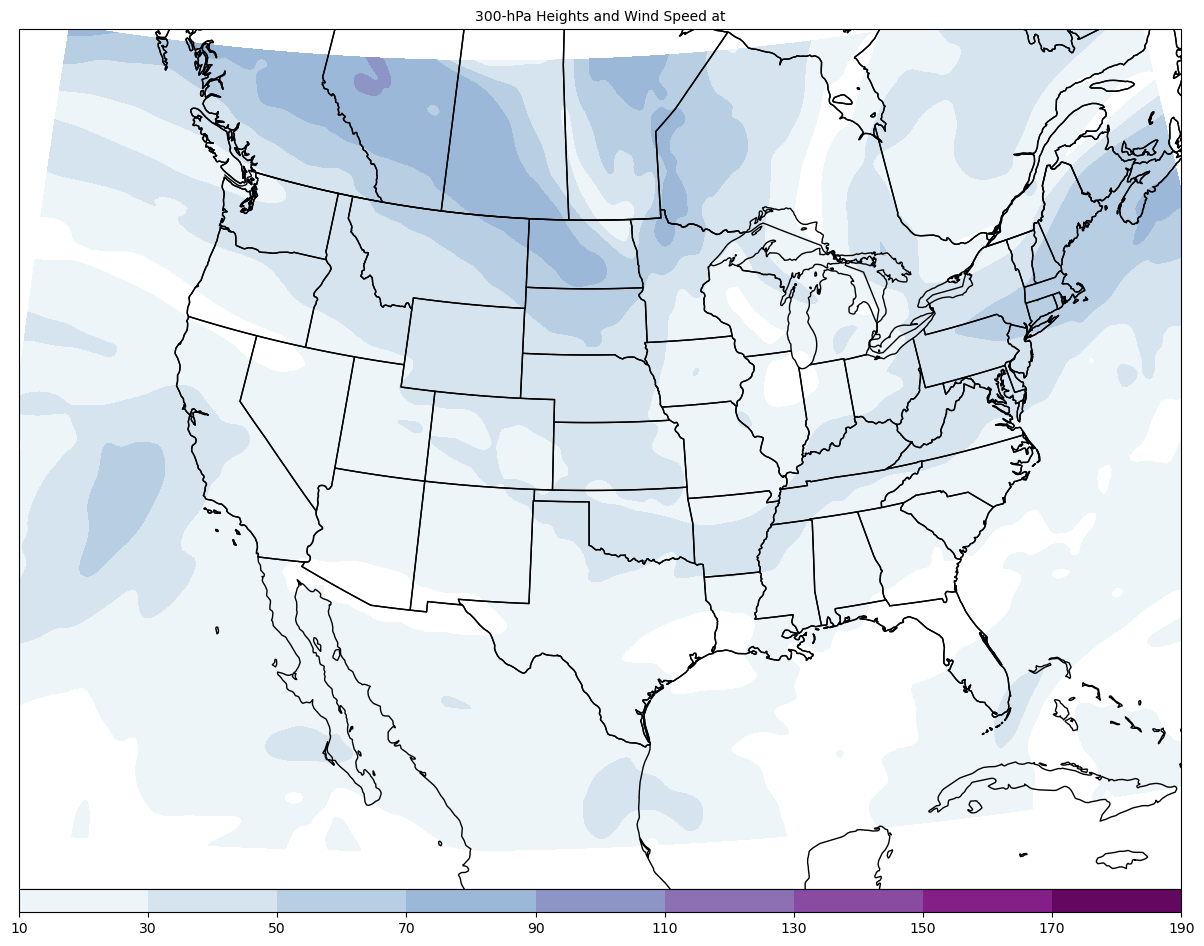

In [40]:
pc.show()